[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/18_paper.cnn.valid_curve_by_tax.ipynb)

# 4.4. Validation curve by Soil Taxonomy Orders (CNN)

> CNN validation loss by Soil Taxonomy Orders

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

In [ ]:
# Python utils
import math
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path
import pickle

# mirzai utilities
from mirzai.data.loading import load_kssl
from mirzai.training.core import load_dumps
from mirzai.vis.core import (centimeter, PRIMARY_COLOR, 
                             set_style, DEFAULT_STYLE)

# Data science stack
import pandas as pd
import numpy as np

# Data vis.
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cycler import cycler

import warnings
warnings.filterwarnings('ignore')

## Load and transform

In [ ]:
src_dir = 'data'
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

## Experiment

### Utilities

In [ ]:
def format_tax_losses(losses, idx=None):
    if idx is None:
        losses_tax = []
        for i, loss in enumerate(losses):
            df_seed = pd.DataFrame(loss['valid_tax']).T
            df_seed.index.name = 'tax'
            df_seed.reset_index()
            losses_tax.append(df_seed)
        df = pd.concat(losses_tax)
        return df.reset_index().groupby('tax').mean().reset_index()
    else:
        df_seed = pd.DataFrame(losses[idx]['valid_tax']).T
        df_seed.index.name = 'tax'
        df_seed.reset_index()
        return df_seed

### Setup

In [ ]:
dest_dir_loss = Path('dumps/cnn/train_eval/all/losses')
losses = load_dumps(dest_dir_loss)

In [ ]:
df_loss_all_mean = pd.DataFrame([loss['valid'] for loss in losses]).mean()

In [ ]:
df_loss_all_mean.values

array([0.14582814, 0.09014846, 0.07893631, 0.07276324, 0.07073818,
       0.06707921, 0.0625751 , 0.05599464, 0.05248269, 0.04967756,
       0.046866  , 0.04880906, 0.05141463, 0.05284351, 0.05540708,
       0.05563474, 0.05164713, 0.04905587, 0.04571185, 0.04315375,
       0.04110955, 0.04223788, 0.04455341, 0.04628459, 0.05034362,
       0.05034709, 0.04645335, 0.04503993, 0.0423074 , 0.04000635,
       0.03812311, 0.03942788, 0.04132601, 0.04227399, 0.04667591,
       0.04809851, 0.04418473, 0.04192892, 0.04063427, 0.03810782,
       0.03614225, 0.03727109, 0.03956102, 0.04122068, 0.04300844,
       0.04640118, 0.04282962, 0.04091016, 0.03853729, 0.03682557,
       0.03487694, 0.03627837, 0.03842524, 0.03981313, 0.04410538,
       0.04434885, 0.04282881, 0.03975203, 0.03722999, 0.03535308,
       0.03379202, 0.03589583, 0.03702463, 0.03876628, 0.04165303,
       0.04548378, 0.04082348, 0.03925791, 0.03737891, 0.0351957 ,
       0.03304794, 0.03445445, 0.03572285, 0.03869938, 0.04030

In [ ]:
# Exclude "Oxisols" as too few samples
tax_of_interest = {k: v for k, v in tax_lookup.items() if k != 'oxisols'}
tax_of_interest

{'alfisols': 0,
 'mollisols': 1,
 'inceptisols': 2,
 'entisols': 3,
 'spodosols': 4,
 'undefined': 5,
 'ultisols': 6,
 'andisols': 7,
 'histosols': 8,
 'vertisols': 10,
 'aridisols': 11,
 'gelisols': 12}

In [ ]:
df = format_tax_losses(losses, idx=None).filter(items=tax_of_interest.values(), axis=0); df

,tax,0,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,200
0,0,0.136776,0.056102,0.051624,0.049182,0.046964,0.046138,0.043792,0.039819,0.038829,...,0.026873,0.027761,0.028256,0.028500,0.029622,0.029936,0.027817,0.027758,0.026603,0.025761
1,1,0.108970,0.074844,0.066805,0.060365,0.060410,0.057207,0.053487,0.046880,0.044224,...,0.025806,0.027472,0.028190,0.028275,0.029406,0.029591,0.027757,0.026725,0.025784,0.024443
2,2,0.179343,0.080996,0.071688,0.070212,0.064672,0.065054,0.060657,0.055836,0.054061,...,0.036132,0.037807,0.038594,0.039017,0.039383,0.039225,0.038377,0.037397,0.036353,0.034852
3,3,0.166356,0.087728,0.078601,0.075305,0.066709,0.067684,0.064100,0.057511,0.054260,...,0.029942,0.031722,0.032132,0.032915,0.035358,0.035649,0.031892,0.030620,0.030083,0.028646
4,4,0.197614,0.083122,0.072006,0.068903,0.068574,0.066645,0.065523,0.062196,0.057514,...,0.039557,0.039785,0.040462,0.042845,0.044306,0.044326,0.041461,0.040120,0.039678,0.039088
5,5,0.153747,0.107503,0.092829,0.084751,0.082516,0.076731,0.070696,0.062839,0.057833,...,0.032669,0.034629,0.035730,0.035848,0.037953,0.037656,0.035190,0.034110,0.032548,0.030803
6,6,0.152534,0.064571,0.060710,0.058852,0.059420,0.059187,0.055980,0.054683,0.053309,...,0.038558,0.039243,0.041479,0.041662,0.043007,0.042023,0.040298,0.040001,0.038738,0.037550
7,7,0.169730,0.083335,0.069036,0.065518,0.060544,0.063257,0.060464,0.051612,0.047301,...,0.029281,0.031648,0.032247,0.031448,0.033532,0.033072,0.031675,0.029762,0.028676,0.026958
8,8,0.293496,0.203235,0.151515,0.138089,0.133604,0.122406,0.117703,0.106278,0.100228,...,0.064171,0.067258,0.070667,0.069261,0.071917,0.070003,0.069514,0.068517,0.065218,0.062353
10,10,0.106765,0.070213,0.062454,0.057815,0.055850,0.050079,0.046619,0.039625,0.037970,...,0.022706,0.024911,0.024899,0.025516,0.026076,0.025788,0.025336,0.023495,0.023181,0.021947


In [ ]:
indexes = [i for i in range(len(losses[0]['valid_tax'])) if not i%10]

In [ ]:
df_selected_tax = df[indexes[2:]].T
df_selected_all = df_loss_all_mean[indexes[2:]]

df_selected_tax

,0,1,2,3,4,5,6,7,8,10,11,12
20,0.032607,0.034638,0.045875,0.041617,0.046397,0.043431,0.047601,0.036641,0.081370,0.029222,0.048862,0.061913
30,0.030932,0.032115,0.043283,0.037829,0.043756,0.039932,0.045231,0.034765,0.076238,0.027701,0.044190,0.058242
40,0.029718,0.030283,0.041323,0.035609,0.042389,0.037653,0.043479,0.032929,0.073283,0.027140,0.041524,0.055829
50,0.029158,0.029090,0.040370,0.034228,0.040828,0.036120,0.042232,0.032216,0.071332,0.026365,0.040523,0.054847
60,0.028400,0.028178,0.039149,0.032863,0.040171,0.034912,0.040847,0.031589,0.070367,0.025167,0.039058,0.053372
70,0.027902,0.027529,0.038346,0.031901,0.039783,0.034051,0.040239,0.031052,0.068467,0.024631,0.038168,0.052347
80,0.027659,0.026991,0.037488,0.030898,0.039623,0.033449,0.039798,0.030357,0.067050,0.024588,0.037636,0.051267
90,0.027229,0.026614,0.036943,0.030656,0.039570,0.032891,0.039234,0.030320,0.066097,0.023612,0.036969,0.050530
100,0.027036,0.026320,0.036623,0.029997,0.039183,0.032602,0.038751,0.029793,0.065453,0.023484,0.035918,0.051719
110,0.026978,0.026052,0.036248,0.029669,0.039254,0.032338,0.038368,0.029803,0.064705,0.023107,0.036339,0.050241


## Plot

In [ ]:
def plot_val_losses_tax(df_tax, df_all, tax_lookup,
                        figsize=(16*centimeter, 10*centimeter), dpi=600):
    # Layout 
    fig = plt.figure(figsize=figsize, dpi=600)
    gs = GridSpec(nrows=1, ncols=1)
    ax = fig.add_subplot(gs[0, 0])

    cc = (cycler(color=[f'C{i}' for i in range(7)]) *
          cycler(linestyle=['-', '--']))

    epochs = df_tax.index.to_numpy()
    # Plots
    for tax_label, tax_idx in tax_lookup.items():
        #ax.plot(epochs, np.mean(deltas[:,:,tax_idx], axis=0), 
        ax.plot(epochs, df_tax.loc[:, tax_idx], 
                label=tax_label.capitalize(),
                **list(cc)[tax_idx])
    
    ax.plot(epochs, df_all, 
                label='All',
                c='black')
    # Ornaments
    ax.legend(loc='best', frameon=False, ncol=3) 
    #ax.set_ylabel('$MSE_{test} - MSE_{train}$ →', loc='top')
    ax.set_ylabel('Validation loss (MSE) →', loc='top')
    ax.set_xlabel('Number of epochs →', loc='right')
    ax.grid(True, "minor", color="0.85", linewidth=0.2, zorder=-2)
    ax.grid(True, "major", color="0.65", linewidth=0.4, zorder=-1) 
    plt.tight_layout()

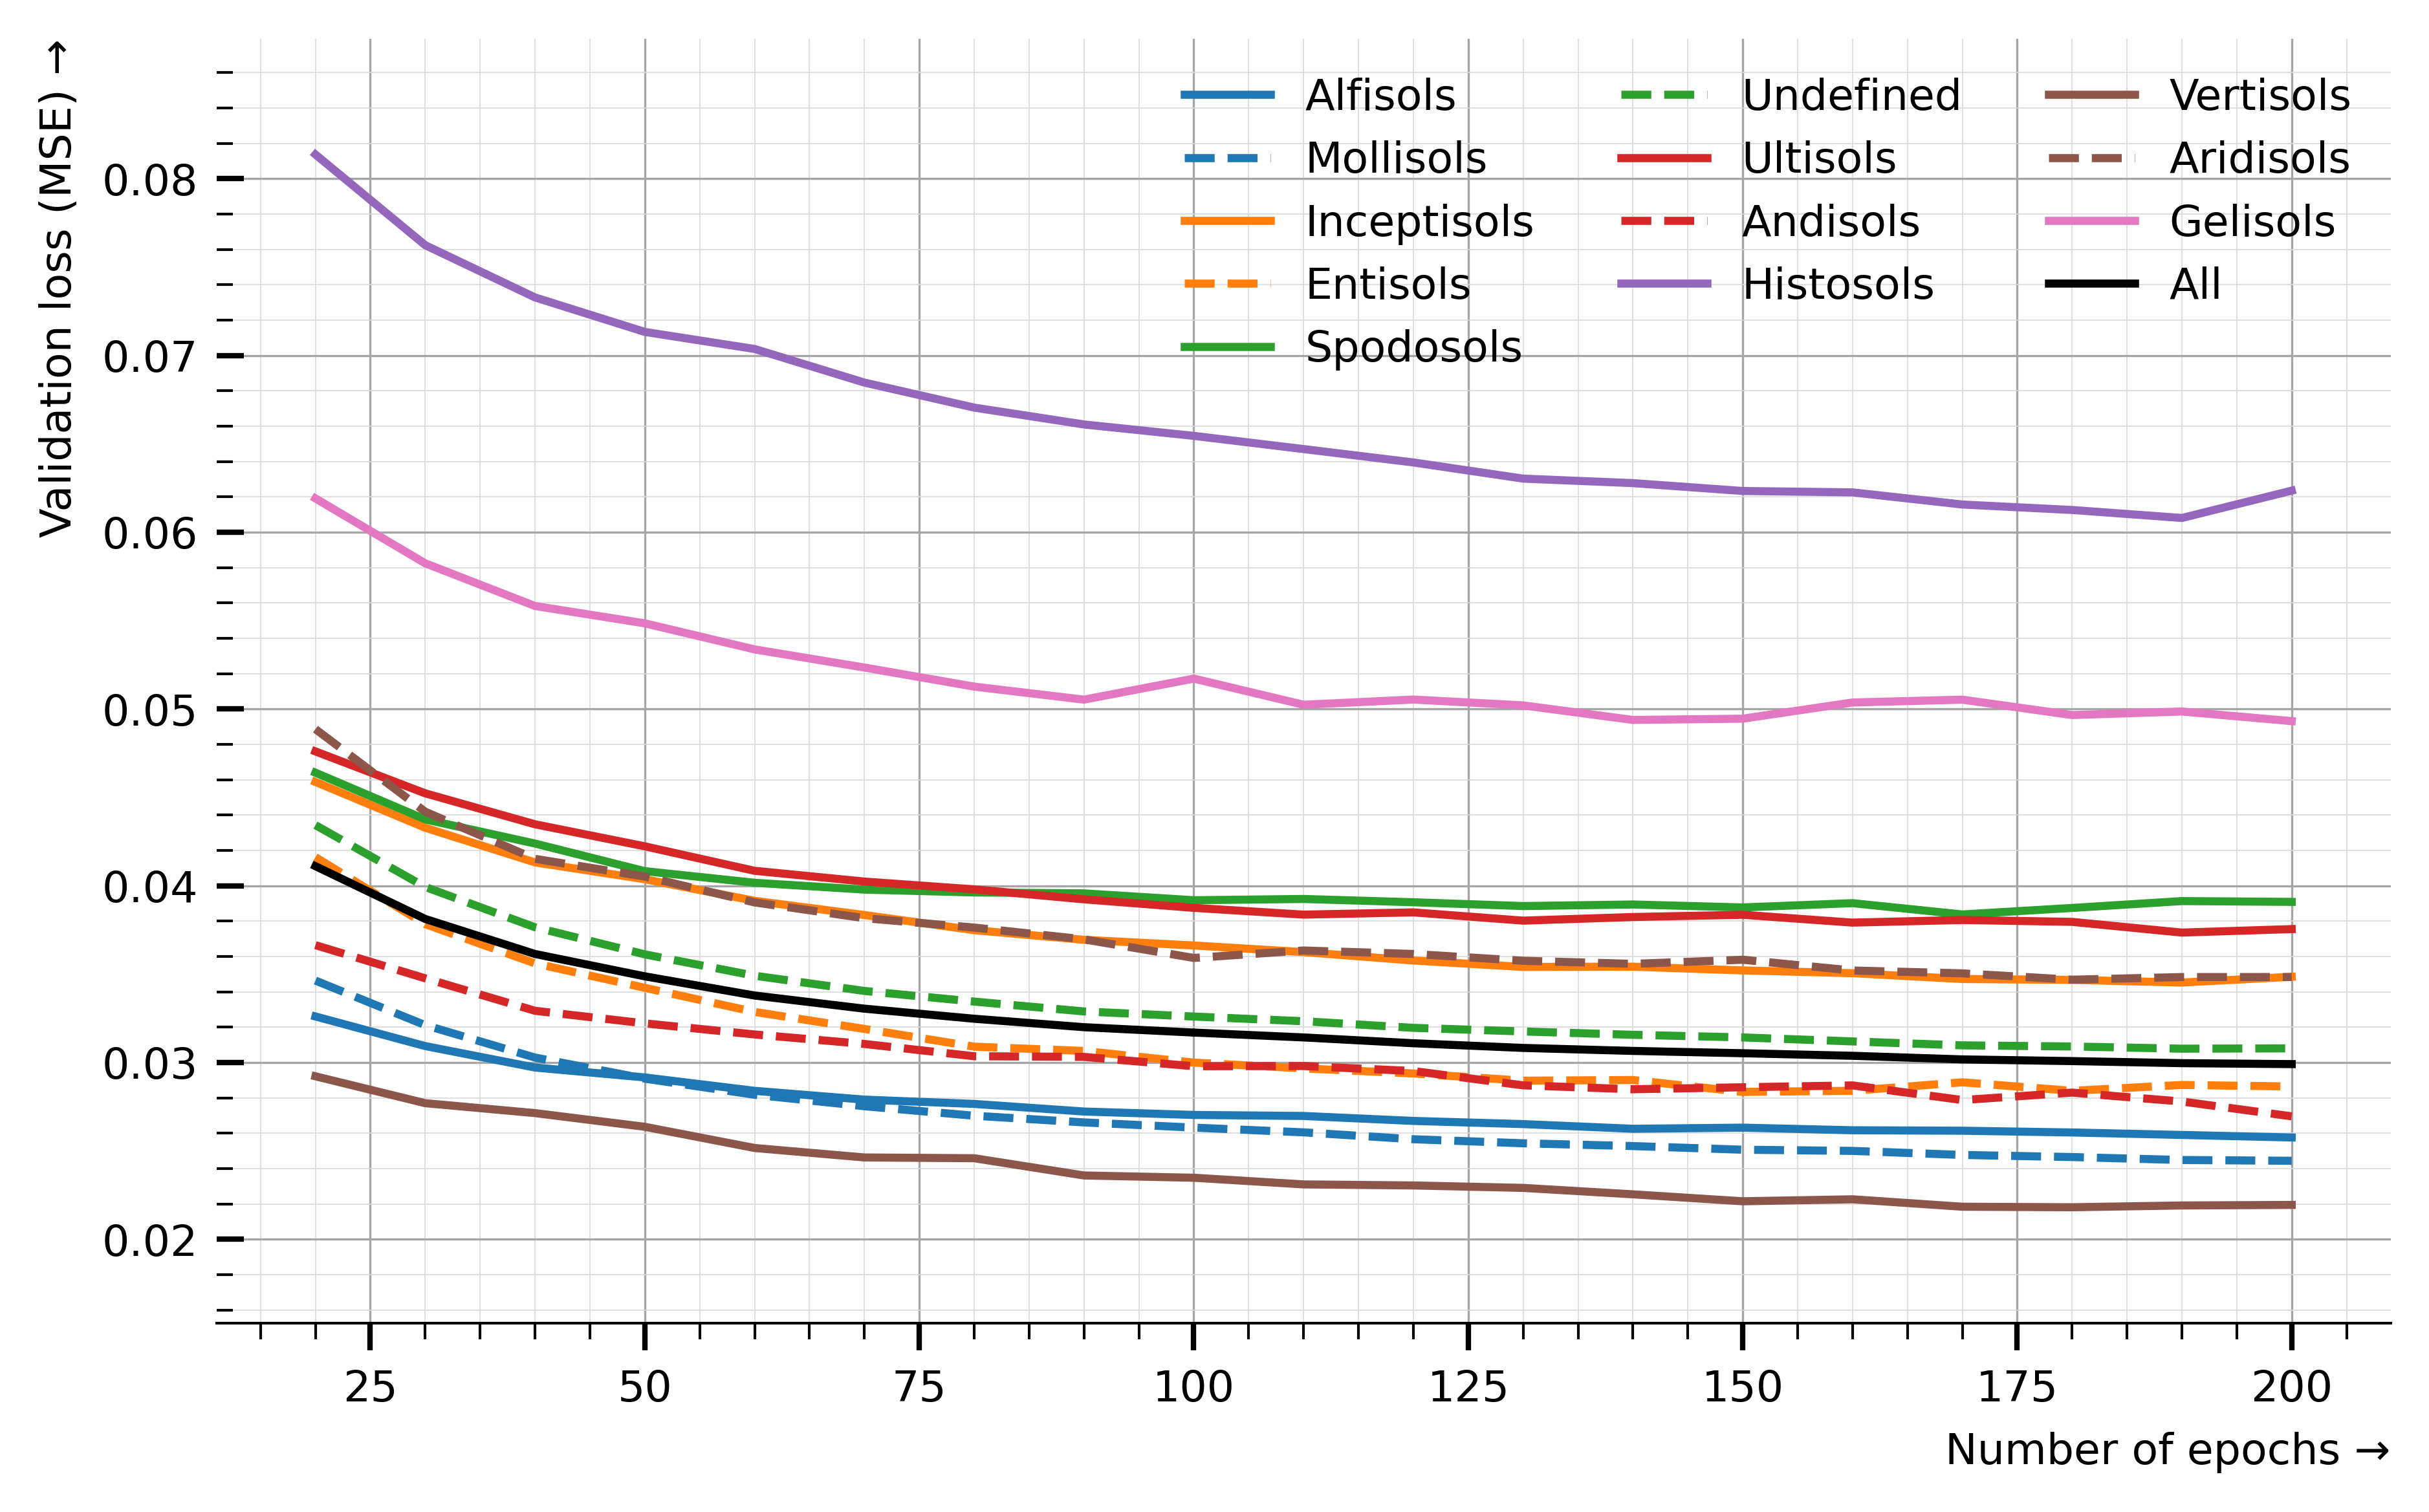

In [ ]:
#FIG_PATH = Path('nameofyourfolder')
FIG_PATH = Path('images')
set_style(DEFAULT_STYLE)
plot_val_losses_tax(df_selected_tax, df_selected_all, tax_of_interest)

# To save/export it
plt.savefig(FIG_PATH/'validation_loss_tax.png', dpi=600, transparent=True, format='png')